<a href="https://colab.research.google.com/github/vascomedici/teaching_project_scc/blob/main/pv_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=1Psvmk5z3zlB8YBmK5PR0vd4J0RLirgKG
To: /content/meteo.csv
100% 1.02M/1.02M [00:00<00:00, 66.1MB/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7effb289b110>,
      dtype=object)

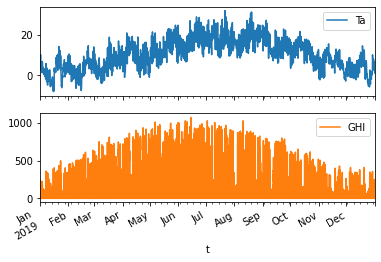

In [2]:
!pip install pvlib
!gdown --id 1Psvmk5z3zlB8YBmK5PR0vd4J0RLirgKG # download meteo data from shared gdrive file
import pvlib
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y %H:%M:%S')
meteo = pd.read_csv('meteo.csv', header=0, parse_dates=[0], date_parser=date_parser, index_col=0)
meteo.plot(subplots=True)

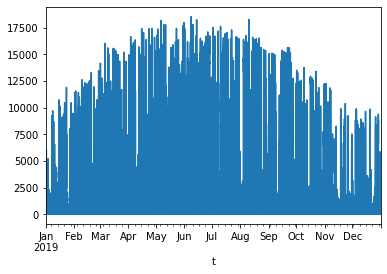

In [4]:
latitude = 47.03
longitude = 8.296
altitude = 460
albedo = 0.1

tilt = 15
azimuth = 193

location = pvlib.location.Location(latitude, longitude, 'Etc/GMT+1', altitude)
sun_pos = location.get_solarposition(meteo.index)
ghi = meteo['GHI']
dni = pvlib.irradiance.dirint(meteo['GHI'], sun_pos['zenith'], sun_pos.index)
dni.fillna(0, inplace=True)
dhi = ghi - np.cos(np.deg2rad(sun_pos['zenith'])) * dni


aoi = pvlib.irradiance.aoi(tilt, azimuth, sun_pos['zenith'], sun_pos['azimuth'])
irr = pvlib.irradiance.get_total_irradiance(tilt, azimuth, sun_pos['zenith'], sun_pos['azimuth'], dni, ghi, dhi,
                                      albedo=0.1, model_perez='allsitescomposite1990')


p_module = 300  # potenza del modulo in 300W (1m x 1.7m) (non cambiare)
num_modules = 66  # numero di moduli

# correzione per angolo d'incidenza in base alle caratteristiche del modulo
b0 = 0.05
iam = np.maximum(1 - b0 * (1 / np.cos(np.minimum(np.deg2rad(aoi), np.pi/2)) - 1), 0)

irr['poa_eff'] = iam * irr['poa_direct'] + 0.95 * (irr['poa_diffuse'])
# correzione per la temperatura in base alle caratteristiche del modulo
gamma = -0.34 / 100
t_nom = 25
t_bom = meteo['Ta'] + irr['poa_eff'] * (0.0284 + 3e-3)
irr['poa_eff_tc'] = irr['poa_eff'] * (1 + gamma * (t_bom - t_nom))

# correzione per la potenza a basso irraggiamento di modulo e inverter
k2 = 0.942
k3 = -5.02e-2
k4 = -3.77e-2
i_stc = 1000
np.seterr(divide = 'ignore') 
eff = np.maximum(0.1, (k2 + k3 * np.log(irr['poa_eff_tc'] / i_stc) + k4 * np.log(irr['poa_eff_tc'] / i_stc)**2).fillna(0))
np.seterr(divide = 'warn') 
irr['poa_eff_tc_li'] = irr['poa_eff_tc'] * eff

# potenza dell'impianto in W
p_plant = p_module * irr['poa_eff_tc_li'] / 1000 * num_modules

p_plant.plot()

e_plant = p_plant / 1000 * (p_plant.index[1]- p_plant.index[0]).seconds / 3600 # W to kWh

# save_path = 'Energia_PV.csv'
# e_plant.to_csv(save_path, sep=',', date_format='%Y-%m-%dT%H:%M:%S', float_format='%.03f')